# Total images 1183 calss 3 {Cataracts, Normal_Eyes, Uveitis}

# Pretrained Model Use( EfficientNetB3 )

In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="Private")
project = rf.workspace("khalid-khubrani").project("eye-disease-classification-iu3lf-vjtmp")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Eye-disease-classification-1 in folder:: 100%|██████████| 1196/1196 [00:00<00:00, 6424.56it/s]


In [ ]:
# Imports
from roboflow import Roboflow
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


# Prepare Data Generators

In [ ]:
train_dir = dataset.location + "/train"
val_dir   = dataset.location + "/valid"
test_dir  = dataset.location + "/test"

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_data = val_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

num_classes = len(train_data.class_indices)
print("Classes:", train_data.class_indices)


Found 962 images belonging to 3 classes.
Found 72 images belonging to 3 classes.
Found 149 images belonging to 3 classes.
Classes: {'Cataracts': 0, 'Normal_Eyes': 1, 'Uveitis': 2}


# Build Pretrained Model (EfficientNetB3 Fine-Tuning)

In [ ]:
base_model = EfficientNetB3(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

# Unfreeze only the last 25 layers for fine-tuning
for layer in base_model.layers[:-25]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)




# Compile

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



# Model Summary

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,788,146 (41.15 MB)

 Trainable params: 3,540,685 (13.51 MB)

 Non-trainable params: 7,247,461 (27.65 MB)

# Callbacks

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_eye_model.h5", monitor='val_accuracy', save_best_only=True
)

# Train Model

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5526 - loss: 0.9486

31/31 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5544 - loss: 0.9457 - val_accuracy: 0.6111 - val_loss: 0.8112
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7499 - loss: 0.6213

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step - accuracy: 0.7504 - loss: 0.6202 - val_accuracy: 0.8333 - val_loss: 0.5700
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8208 - loss: 0.4791

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - accuracy: 0.8207 - loss: 0.4796 - val_accuracy: 0.9167 - val_loss: 0.4174
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.8415 - loss: 0.4405 - val_accuracy: 0.9028 - val_loss: 0.3842
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.8961 - loss: 0.3336 - val_accuracy: 0.8611 - val_loss: 0.3785
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.8629 - loss: 0.3574 - val_accuracy: 0.8750 - val_loss: 0.3910
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 0.9158 - loss: 0.2876 - val_accuracy: 0.8750 - val_loss: 0.3330
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.9169 - loss: 0.2512 - val_accuracy: 0.8889 - val_loss: 0.3524
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.9171 - loss: 0.2272 - val_accuracy: 0.9028 - val_loss: 0.3338
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.9203 - loss: 0.2322 - val_accuracy: 0.90

# Evaluate Model

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
test_loss, test_acc = model.evaluate(test_data)

print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8789 - loss: 0.3332
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9334 - loss: 0.2363

Validation Accuracy: 0.8750
Test Accuracy: 0.9396


# Plot Accuracy & Loss Curves

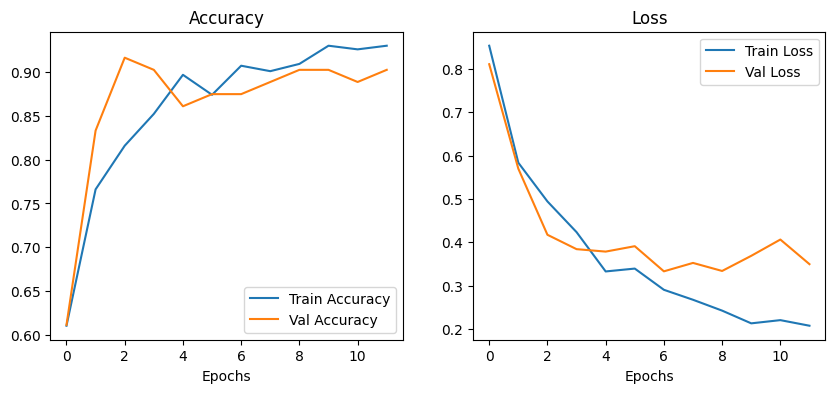

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epochs')

plt.show()


# Confusion Matrix + Report

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


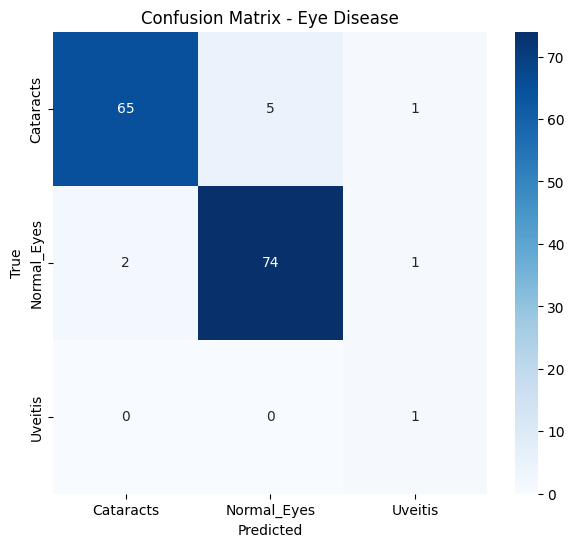


 Classification Report:
              precision    recall  f1-score   support

   Cataracts       0.97      0.92      0.94        71
 Normal_Eyes       0.94      0.96      0.95        77
     Uveitis       0.33      1.00      0.50         1

    accuracy                           0.94       149
   macro avg       0.75      0.96      0.80       149
weighted avg       0.95      0.94      0.94       149



In [ ]:
# Predict on test data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Eye Disease")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


# Save Model

In [ ]:
model.save("eye_disease_finetuned.h5")
print("Model saved as eye_disease_finetuned.h5")


Model saved as eye_disease_finetuned.h5


# Load Model & Predict New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


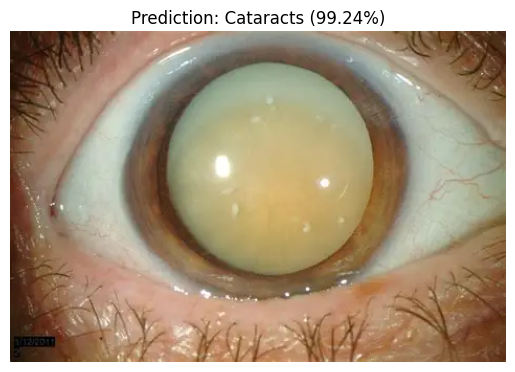

Predicted: Cataracts (99.24%)


In [ ]:
from tensorflow.keras.preprocessing import image
import cv2

# Load model
model = load_model("eye_disease_finetuned.h5")
class_labels = list(train_data.class_indices.keys())

# Path to single test image
img_path = "/content/Cataracts.webp"  # change path to your image

# Preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred)
pred_label = class_labels[pred_class]
confidence = np.max(pred) * 100

plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {pred_label} ({confidence:.2f}%)")
plt.axis('off')
plt.show()

print(f"Predicted: {pred_label} ({confidence:.2f}%)")
